In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as web
import numpy as np

In [4]:
tickers = ["AAPL", "MSFT", "GOOG", "NVDA"]

In [5]:
data = pd.DataFrame()
for t in tickers:
    data[t] = web.DataReader(t, data_source="yahoo", start="2009-1-1")["Adj Close"]

In [6]:
data.head()

,AAPL,MSFT,GOOG,NVDA
Date,,,,
2009-01-02,11.253528,15.592469,160.060059,8.016504
2009-01-05,11.728474,15.738195,163.412491,8.163763
2009-01-06,11.535025,15.922266,166.406265,8.439878
2009-01-07,11.285772,14.963554,160.403763,7.933669
2009-01-08,11.495339,15.431399,161.987823,7.731187


In [7]:
daily_returns = data.pct_change()

In [8]:
port_voc = daily_returns.cov()

In [9]:
daily_returns.head()

,AAPL,MSFT,GOOG,NVDA
Date,,,,
2009-01-02,NaN,NaN,NaN,NaN
2009-01-05,0.042204,0.009346,0.020945,0.018369
2009-01-06,-0.016494,0.011696,0.018320,0.033822
2009-01-07,-0.021608,-0.060212,-0.036071,-0.059978
2009-01-08,0.018569,0.031266,0.009875,-0.025522


In [10]:
port_voc.head()

,AAPL,MSFT,GOOG,NVDA
AAPL,0.000307,0.000145,0.000152,0.000215
MSFT,0.000145,0.000266,0.000152,0.000219
GOOG,0.000152,0.000152,0.000264,0.000206
NVDA,0.000215,0.000219,0.000206,0.000753


### Random allocaitons

In [11]:
number_of_ports = 2000
all_weights = np.zeros((number_of_ports, len(data.columns)))
all_Returns = np.zeros(number_of_ports)
all_vol = np.zeros(number_of_ports)
all_sharps = np.zeros(number_of_ports)

## loop 
for ind in range(number_of_ports):
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    all_weights[ind,:] = weights
    all_Returns[ind] = np.sum(daily_returns.mean() * weights) * 252
    all_vol[ind] = np.sqrt(np.dot(weights.T, np.dot(port_voc * 252, weights)))
    all_sharps[ind] = all_Returns[ind]/all_vol[ind]

In [27]:
max_sharp = all_sharps.argmax()
max_sharp

49

In [28]:
lowest_vol = all_vol.argmin()
lowest_vol

697

In [14]:
highest_return = all_Returns.argmax()

#### plot the graph for the portfolios in the frontier

The Max sharp is the weights of [0.5719564  0.20914652 0.05589671 0.16300037]
 where the highest return is [0.01446868 0.06815543 0.01020666 0.90716923]
the lowest Risk would have weights of [0.27889518 0.34221881 0.37412537 0.00476064]


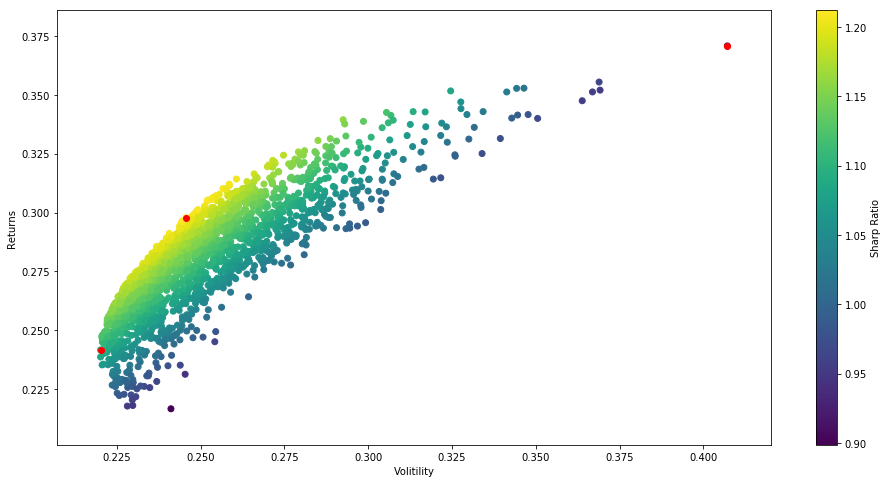

In [51]:
plt.figure(figsize=(16,8))
plt.scatter(all_vol, all_Returns, c=all_sharps)
plt.colorbar(label = "Sharp Ratio")
plt.scatter(all_vol[lowest_vol], all_Returns[lowest_vol], c = "r")
plt.scatter(all_vol[highest_return], all_Returns[highest_return], c = "r")
plt.scatter(all_vol[max_sharp], all_Returns[max_sharp], c = "r")
plt.xlabel("Volitility")
plt.ylabel("Returns")

print(f"The Max sharp is the weights of {all_weights[max_sharp]}\n where the highest return is {all_weights[highest_return]}\nthe lowest Risk would have weights of {all_weights[lowest_vol]}")


### Mathmatically 

In [52]:
from scipy.optimize import minimize

In [53]:
def ret_vol_shp(weights):
    ret = np.sum(daily_returns.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))
    shp = ret/vol
    return np.array([ret,vol,shp])

In [54]:
def minimize_Sharp(weights):
    return ret_vol_shp(weights)[2] * -1

In [55]:
def check_weights(weights):
    return np.sum(weights) - 1

In [56]:
bounds = ((0,1),)* len(data.columns)
bounds

((0, 1), (0, 1), (0, 1), (0, 1))

In [57]:
initial_guess = [0.25] * len(data.columns)
initial_guess

[0.25, 0.25, 0.25, 0.25]

In [58]:
cons = {"type":"eq", "fun": check_weights}

In [59]:
opt = minimize(minimize_Sharp, initial_guess, method="SLSQP", bounds= bounds,constraints=cons)

### Best weights are represented by x i nthe resultes below and the best sharp is said to be 1.21 which is just about the same as the random allocations above

In [60]:
opt

     fun: -1.2129539126782414
     jac: array([ 1.19671226e-04, -6.07818365e-05,  3.36170197e-04, -3.57881188e-04])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.57157549, 0.22173002, 0.02743133, 0.17926315])

### Lets check the Returns, volitility, and Sharp using the result for Scipy

In [61]:
ret_vol_shp(opt.x)

array([0.30104919, 0.24819508, 1.21295391])

###  we are to expect a 30% return, about a 25% vol to get a sharp of 1.21. We will use this data to plot the effieicnt frontier using scipy minimize function

In [62]:
fronter_vol = []

In [63]:
def min_vol(weights):
    return ret_vol_shp(weights)[1]

In [65]:
frontier_y = np.linspace(0.2,0.4,100)
for potential_return in frontier_y:
    const = ({"type":"eq", "fun": check_weights}, {"type":"eq", "fun":lambda x: ret_vol_shp(x)[0] - potential_return})
    results = minimize(min_vol, initial_guess, method="SLSQP", bounds=bounds, constraints=const)
    fronter_vol.append(results["fun"])
    

Text(0, 0.5, 'Returns')

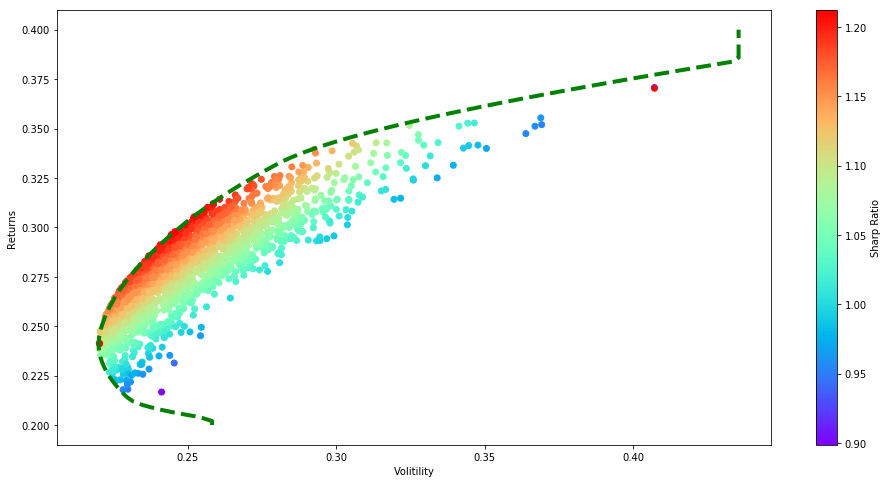

In [76]:
plt.figure(figsize=(16,8))
plt.scatter(all_vol, all_Returns, c=all_sharps, cmap="rainbow")
plt.colorbar(label = "Sharp Ratio")
plt.scatter(all_vol[lowest_vol], all_Returns[lowest_vol], c = "r", s = 40)
plt.scatter(all_vol[highest_return], all_Returns[highest_return], c = "r", s = 30)
plt.scatter(all_vol[max_sharp], all_Returns[max_sharp], c = "r", s = 30)
plt.plot(fronter_vol, frontier_y, lw = 4, ls = "--", c= "g")
plt.xlabel("Volitility")
plt.ylabel("Returns")